In [1]:
import tensorflow as tf
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


In [2]:
!git clone --depth 1 -b v2.5.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [3]:
!pip install -Uqr models/official/requirements.txt

In [1]:
#after restart the runtime

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')

from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [2]:
print("TF Version: ", tf.__version__)
print("Eager Mode: ", tf.executing_eagerly())
print("Hub Version: ", hub.__version__)
print("GPU is", "available." if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE.")

TF Version:  2.5.0
Eager Mode:  True
Hub Version:  0.12.0
GPU is NOT AVAILABLE.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
#df = pd.read_csv('/content/gdrive/MyDrive/Data/new_tweets.csv')
df = pd.read_csv('/content/gdrive/MyDrive/Data/Merge_Dataset.csv')
#df = pd.read_csv('/content/gdrive/MyDrive/Data/numeric_lable.csv')
df.head()

,text,lable
0,i didnt feel humiliated,negative
1,i can go from feeling so hopeless to so damned...,negative
2,im grabbing a minute to post i feel greedy wrong,negative
3,i am ever feeling nostalgic about the fireplac...,positive
4,i am feeling grouchy,negative


In [6]:
df.shape

(21783, 2)

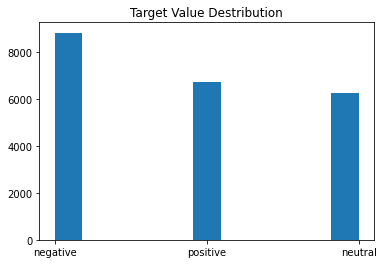

In [7]:
import matplotlib.pyplot as plt
plt.hist(df.lable, bins=11)
plt.title("Target Value Destribution")
plt.show()

In [8]:
class_to_index = dict((c, i) for i,c in enumerate(set(df.lable)))
index_to_class = dict((v, k) for k, v in class_to_index.items())
class_to_index

{'negative': 0, 'neutral': 1, 'positive': 2}

In [9]:
index_to_class

{0: 'negative', 1: 'neutral', 2: 'positive'}

In [11]:
df['lable'] = df.lable.replace(class_to_index)
df.head()

,text,lable
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,0


In [12]:
train_df, remaining = train_test_split(df, random_state = 42, train_size = 0.8, stratify = df.lable.values)
valid_df, _ = train_test_split(remaining, random_state = 42, train_size = 0.2, stratify = remaining.lable.values)
train_df.shape, valid_df.shape

((17426, 2), (871, 2))

In [13]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['text'].values, train_df['lable'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.text.values, valid_df.lable.values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'i started to feel a sweet feeling of peace', shape=(), dtype=string)
tf.Tensor(2, shape=(), dtype=int64)


In [14]:
#label_list = ['negative', 'positive', 'neutral'] #based on target value catagories
cls = set(df.lable)
label_list = list(cls)
max_seq_length = 128
train_batch_size = 32

#Get BERT layer and Tokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

print(label_list)

[0, 1, 2]


In [15]:
tokenizer.wordpiece_tokenizer.tokenize('Hi, How are you doing?') #showing the token

['[UNK]', '[UNK]', 'are', 'you', 'doing', '##?']

In [16]:
#Convert to Token IDs that BERT requires
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('Hi, How are you doing?'))

[100, 100, 2024, 2017, 2725, 29632]

In [17]:
#This function convert the raw to input features and label
def to_feature(text, label, label_list = label_list, max_seq_length = max_seq_length, tokenizer = tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [18]:
#wrapper function
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature,inp = [text, label],
                                                                Tout = [tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
  }

  return (x, label_id)

In [19]:
#Tensorflow Input Pipeline
with tf.device('/cpu:0'):
  #train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  #valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))

In [20]:
#train data specification
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [21]:
#valid data specification
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [22]:
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.3)(pooled_output)
  dense_1 = tf.keras.layers.Dense(512, activation='relu')(drop)
  dense_2 = tf.keras.layers.Dense(1024, activation='relu')(dense_1)
  dense_3 = tf.keras.layers.Dense(1024, activation='relu')(dense_2)
  drop = tf.keras.layers.Dropout(0.4)(dense_3)
  output = tf.keras.layers.Dense(3, activation = 'sigmoid', name = 'output')(drop)

  model = tf.keras.Model(
      inputs = {
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs = output)
  return model

In [23]:
model = create_model()
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer='adam', metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]) #for catagorical label we will use sparse catagorical entropy instead of Binary cross entropy

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

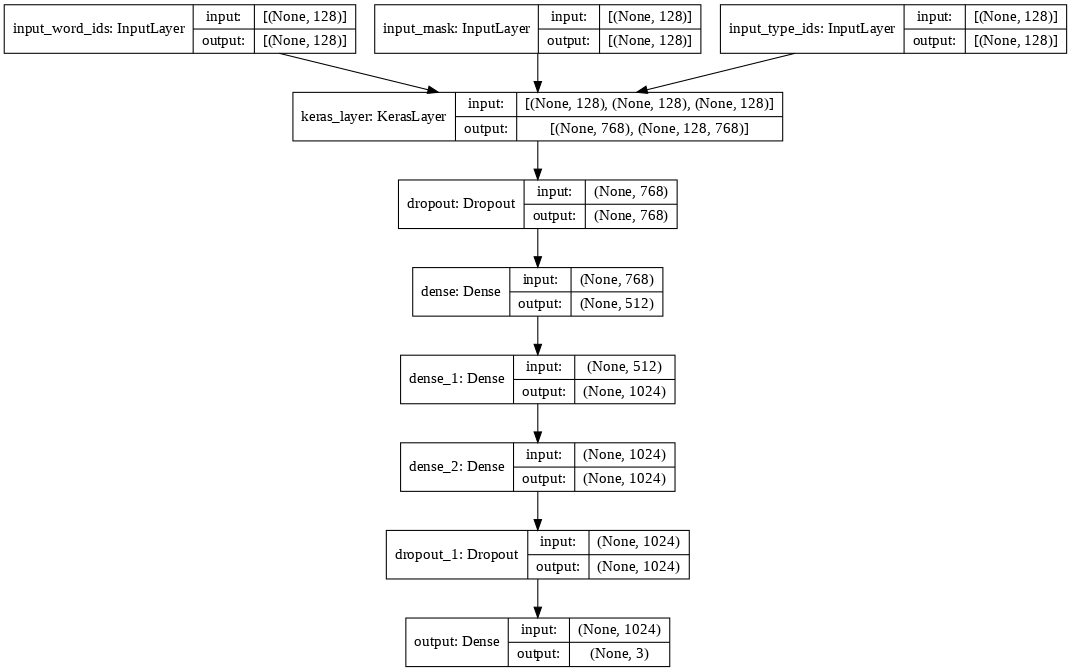

In [24]:
tf.keras.utils.plot_model(model = model, show_shapes = True, dpi = 76)

In [ ]:
#Train Model
epochs = 2
history = model.fit(train_data,
                    validation_data = valid_data,
                    epochs = epochs,
                    verbose = 1)

Epoch 1/2
267/544 [=============>................] - ETA: 3:18:24 - loss: 0.8709 - sparse_categorical_accuracy: 0.5287

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
plot_graphs(history, 'sparse_categorical_accuracy')

In [ ]:
sample_example = ['may i have your number??', 'Can I ask my girl to go on a data after a big fight?']
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map)).batch(1)
pred = model.predict(test_data)[0][0]
pred_class = index_to_class[np.argmax(pred).astype('uint8')]
print('Predicted Emotion: ', pred_class)
print(f'Test loss: {pred[0]} / Test accuracy: {pred[0]}')
# threshold = 0.5 #we can't use this value for more then 2 target values, we have to edit it.
# ['Insincere' if pred>=threshold else 'Sincere']